# Long-term encoding

### Set-up

In [1]:
import random
import numpy as np
from copy import deepcopy
from importlib import reload 

import syntactic_wm as cjn ## Our model
reload(cjn)


################
## Parameters ##
################
num_steps = 50 # number of time steps taken by each word input.
head = 1 # number of time steps buffering the front of each sentence.
tail = 20 # number of time steps buffering the end of each sentence.
no_periods = 30 # number of epochs each sentence is presented to the model.

tau = 0.5 # modifies change in firing rate at each time step to simulate continuous time.

beta = 1 # decay factor of firing rates.

n_word_neurons = 15 # number of word neurons initialised (f)
n_role_neurons = 10 # number of role neurons initialised (c)

gamma = 0.5 # factor dampening connectivity amongst role neurons.

epsilon_cc = 6 # the ceiling of c-c connections when without long-term encoding, while taking into account of negative bias k. 
k_cc = 5 # negative bias, i.e. negative k_cc is the floor of c-c connections.

epsilon_cf = 3 # the ceiling of c-f connections when without long-term encoding, while taking into account of negative bias k. 
k_cf = 1 # negative bias, i.e. negative k_cf is the floor of c-f connections.

h = 2 # normalising factor for inhibition between c-f connections.

W_mc = 5.6 # connectivity between morph and role neurons (non-encodable)
W_mm = -10 # conneectivity between morpheme neurons to itself (non-encodable)

W_ff = -0.5  # connectivity amongst word neurons (non-encodable)

unified_noise = 0 # noise level if noise is present
cc_noise = False # any noise amongst role neurons
wc_noise = False # any noise between role and word neurons

k_L_cc = 5.7 # long-term encoding amongst role neurons 
k_L_cf = 1.7 # long-term encoding between role and word neurons

# random seed only helpful during long-term acquisition of syntactic knowledge
seed_ = 0 # setting default random seed
np.random.seed(seed_)
random.seed(seed_)

### Simulation 13: Pivot Grammar for long-term word-to-role encoding

In the first part of long-term knowledge acquisition, we make use of pivot grammar to acquire long-term encodings for word-to-role encodings.

In [2]:
# the pivot_grammar flag switches on long-term acquisition between word and role neurons. 
# Encoding within roles layer is switched off.
pivot_grammar = True 
LT_wc_knowledge = [] # no long-term encoding
LT_cc_knowledge = [] # no long-term encoding
long_term_learning = True # switches off short-term synaptic plasticity

lambda_cc = 20/1000 
lambda_cf = 1/1000 

sentence = []
for n in range(head): sentence.append(cjn.in_in())
for n in range(num_steps): sentence.append(cjn.in_in(word=1, role=1)) # the role neuron is activated simultaneously with the word neuron
for n in range(num_steps): sentence.append(cjn.in_in(word=2, role=2))
for n in range(tail): sentence.append(cjn.in_in())


## initialising the working memory model
WM_ori = cjn.feature_layer(n_role_neurons = n_role_neurons,
                       cc_connectivity_factor = gamma,
                       activation_decay = beta,
                       LR_c = lambda_cc,
                       LR_w = lambda_cf,
                       cc_max_connection = epsilon_cc - k_cc,
                       cf_max_connection = epsilon_cf - k_cf,
                       n_word_neurons = n_word_neurons,
                       time_factor = tau,
                       LT_wc_knowledge = LT_wc_knowledge,
                       cc_learnt_weight = k_L_cc - k_cc,
                       cf_learnt_weight = k_L_cf - k_cf,
                       input_node_connectivity = W_ff,
                       LT_cc_knowledge = LT_cc_knowledge,
                       cc_floor_weight = -k_cc, 
                       cf_floor_weight = -k_cf,
                       unified_noise = unified_noise,
                       cc_noise = cc_noise,
                       wc_noise = wc_noise,
                       cf_conj_factor = h,
                       mc_connectivity_factor = W_mc,
                       mm_connectivity_factor = W_mm,
                       pivot_grammar = pivot_grammar,
                       long_term_learning = long_term_learning  
                      )


# running the 30 epochs of long-term acquisition
role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM_ori, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM_ori, time_steps=len(sentence)*no_periods, sentence=sentence)


********************
Epoch = 1
Number of recorded time steps:  121
********************
Epoch = 2
Number of recorded time steps:  242
********************
Epoch = 3
Number of recorded time steps:  363
********************
Epoch = 4
Number of recorded time steps:  484
********************
Epoch = 5
Number of recorded time steps:  605
********************
Epoch = 6
Number of recorded time steps:  726
********************
Epoch = 7
Number of recorded time steps:  847
********************
Epoch = 8
Number of recorded time steps:  968
********************
Epoch = 9
Number of recorded time steps:  1089
********************
Epoch = 10
Number of recorded time steps:  1210
********************
********************
Epoch = 11
Number of recorded time steps:  1331
********************
Epoch = 12
Number of recorded time steps:  1452
********************
Epoch = 13
Number of recorded time steps:  1573
********************
Epoch = 14
Number of recorded time steps:  1694
********************
Epoch = 1

### Visualisation of long-term encoding

We can visualise the gradual learning of long-term semantic knowledge.

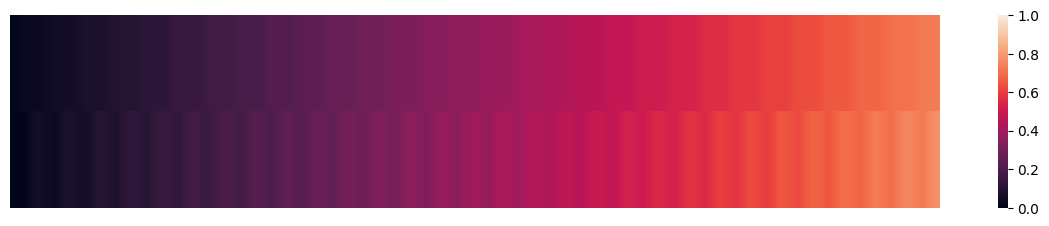

In [3]:
connections_to_track = [[1,1],[2,2]] # tracking word to role connections

cjn.long_term_encoding_plot(wc_long_weights_hx,connections_to_track)  

### Simulation 14: Long-term acquisition of syntactic structure

Next, the model is presented with random sentences of the same syntax. <br>
The model is expected to picture long-term syntactic knowledge after seeing these sentences.

In [15]:
pivot_grammar = False # switch off pivot grammar from before

LT_wc_knowledge = [[0,0],[3,1],[6,2],[9,3],[12,4],
                   [1,0],[4,1],[7,2],[10,3],[13,4],
                   [2,0],[5,1],[8,2],[11,3],[14,4],
                  ] # for each role, there are three possible words
LT_cc_knowledge = [] # no long-term c-c encoding
long_term_learning = True
lambda_cc = 20/50 
lambda_cf = 1/50 
no_periods = 1 # number of epochs is set to 1, because we change the sentence after each epoch

## we need to randomly generate the sentences to input
sentence_index = np.random.randint(3, size=(5, 30)) # 30 sentences of 5 words each
collection_of_sentences = []
for j in range(30):
    sentence = []
    for n in range(head): sentence.append(cjn.in_in())
    for n in range(num_steps): sentence.append(cjn.in_in(word=sentence_index[0,j]))
    for n in range(num_steps): sentence.append(cjn.in_in(word=sentence_index[1,j]+3))
    for n in range(num_steps): sentence.append(cjn.in_in(word=sentence_index[2,j]+6))
    for n in range(num_steps): sentence.append(cjn.in_in(word=sentence_index[3,j]+9))
    for n in range(num_steps): sentence.append(cjn.in_in(word=sentence_index[4,j]+12))
    for n in range(tail): sentence.append(cjn.in_in())
    collection_of_sentences.append(sentence)
    
## initialising the working memory model
WM_ori = cjn.feature_layer(n_role_neurons = n_role_neurons,
                       cc_connectivity_factor = gamma,
                       activation_decay = beta,
                       LR_c = lambda_cc,
                       LR_w = lambda_cf,
                       cc_max_connection = epsilon_cc - k_cc,
                       cf_max_connection = epsilon_cf - k_cf,
                       n_word_neurons = n_word_neurons,
                       time_factor = tau,
                       LT_wc_knowledge = LT_wc_knowledge,
                       cc_learnt_weight = k_L_cc - k_cc,
                       cf_learnt_weight = k_L_cf - k_cf,
                       input_node_connectivity = W_ff,
                       LT_cc_knowledge = LT_cc_knowledge,
                       cc_floor_weight = -k_cc, 
                       cf_floor_weight = -k_cf,
                       unified_noise = unified_noise,
                       cc_noise = cc_noise,
                       wc_noise = wc_noise,
                       cf_conj_factor = h,
                       mc_connectivity_factor = W_mc,
                       mm_connectivity_factor = W_mm,
                       pivot_grammar = pivot_grammar,
                       long_term_learning = long_term_learning  
                      )

# present each of the 30 randomly generated sentences to the network, sequentially, without reset between each epoch.
cc_long_weights_hx_collection = []
for n in range(30):
    role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM_ori, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM_ori, time_steps=len(sentence)*no_periods, sentence=collection_of_sentences[n])
    cc_long_weights_hx_collection.append(cc_long_weights_hx)
cc_long_weights_hx_collection = np.asarray(cc_long_weights_hx_collection)
cc_long_weights_hx_collection = cc_long_weights_hx_collection.reshape(-1,10,10)

********************
Epoch = 1
Number of recorded time steps:  271
********************
********************
Epoch = 1
Number of recorded time steps:  271
********************
********************
Epoch = 1
Number of recorded time steps:  271
********************
********************
Epoch = 1
Number of recorded time steps:  271
********************
********************
Epoch = 1
Number of recorded time steps:  271
********************
********************
Epoch = 1
Number of recorded time steps:  271
********************
********************
Epoch = 1
Number of recorded time steps:  271
********************
********************
Epoch = 1
Number of recorded time steps:  271
********************
********************
Epoch = 1
Number of recorded time steps:  271
********************
********************
Epoch = 1
Number of recorded time steps:  271
********************
********************
Epoch = 1
Number of recorded time steps:  271
********************
********************
Epoch = 1
N

### Visualisation of long-term encoding

We can visualise the gradual learning of long-term syntactic knowledge.

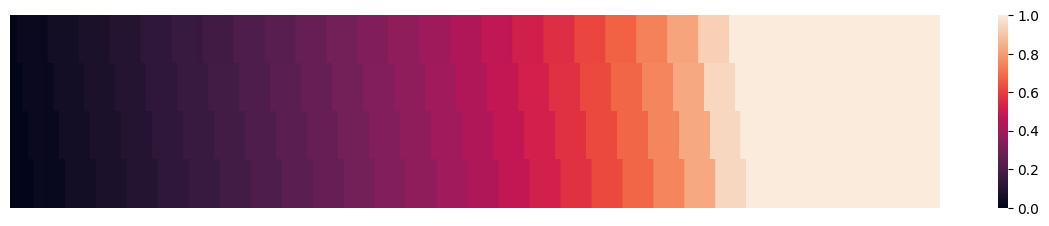

In [16]:
connections_to_track = [[0,1],[1,2],[2,3],[3,4]] # tracking role to role connections

cjn.long_term_encoding_plot(cc_long_weights_hx_collection,connections_to_track)  